In [1]:
######################## train YOLOv3 example ########################
import os
import argparse
import ast
from easydict import EasyDict as edict
import shutil

import numpy as np
import mindspore.nn as nn
from mindspore import context, Tensor
from mindspore.communication.management import init
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.context import ParallelMode
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.common.initializer import initializer
from mindspore.common import set_seed

import sys
sys.path.insert(0,'./yolov3/yolov3_resnet18/')      #yours code path
#sys.path.insert(0,'./yolov3/code/')
from src.yolov3 import yolov3_resnet18, YoloWithLossCell, TrainingWrapper
from src.dataset import create_yolo_dataset, data_to_mindrecord_byte_image
from src.config import ConfigYOLOV3ResNet18

import moxing as mox

set_seed(1)

def get_lr(learning_rate, start_step, global_step, decay_step, decay_rate, steps=False):
    """Set learning rate."""
    lr_each_step = []
    for i in range(global_step):
        if steps:
            lr_each_step.append(learning_rate * (decay_rate ** (i // decay_step)))
        else:
            lr_each_step.append(learning_rate * (decay_rate ** (i / decay_step)))
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    lr_each_step = lr_each_step[start_step:]
    return lr_each_step


def init_net_param(network, init_value='ones'):
    """Init the parameters in network."""
    params = network.trainable_params()
    for p in params:
        if isinstance(p.data, Tensor) and 'beta' not in p.name and 'gamma' not in p.name and 'bias' not in p.name:
            p.set_data(initializer(init_value, p.data.shape, p.data.dtype))


def main(args_opt):
    context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=args_opt.device_id)
    if args_opt.distribute:
        device_num = args_opt.device_num
        context.reset_auto_parallel_context()
        context.set_auto_parallel_context(parallel_mode=ParallelMode.DATA_PARALLEL, gradients_mean=True,
                                          device_num=device_num)
        init()
        rank = args_opt.device_id % device_num
    else:
        rank = 0
        device_num = 1

    loss_scale = float(args_opt.loss_scale)
    
    # When create MindDataset, using the fitst mindrecord file, such as yolo.mindrecord0.
    dataset = create_yolo_dataset(args_opt.mindrecord_file,
                                  batch_size=args_opt.batch_size, device_num=device_num, rank=rank)
    dataset_size = dataset.get_dataset_size()
    print('The epoch size: ', dataset_size)
    print("Create dataset done!")

    net = yolov3_resnet18(ConfigYOLOV3ResNet18())
    net = YoloWithLossCell(net, ConfigYOLOV3ResNet18())
    init_net_param(net, "XavierUniform")

    # checkpoint
    ckpt_config = CheckpointConfig(save_checkpoint_steps=dataset_size * args_opt.save_checkpoint_epochs,
                                  keep_checkpoint_max=args_opt.keep_checkpoint_max)
    ckpoint_cb = ModelCheckpoint(prefix="yolov3", directory=cfg.ckpt_dir, config=ckpt_config)

    if args_opt.pre_trained:
        if args_opt.pre_trained_epoch_size <= 0:
            raise KeyError("pre_trained_epoch_size must be greater than 0.")
        param_dict = load_checkpoint(args_opt.pre_trained)
        load_param_into_net(net, param_dict)
    total_epoch_size = 60
    if args_opt.distribute:
        total_epoch_size = 160
    lr = Tensor(get_lr(learning_rate=args_opt.lr, start_step=args_opt.pre_trained_epoch_size * dataset_size,
                       global_step=total_epoch_size * dataset_size,
                       decay_step=1000, decay_rate=0.95, steps=True))
    opt = nn.Adam(filter(lambda x: x.requires_grad, net.get_parameters()), lr, loss_scale=loss_scale)
    net = TrainingWrapper(net, opt, loss_scale)
    
    callback = [LossMonitor(10*dataset_size), ckpoint_cb]
    model = Model(net)
    dataset_sink_mode = cfg.dataset_sink_mode
    print("Start train YOLOv3, the first epoch will be slower because of the graph compilation.")
    model.train(args_opt.epoch_size, dataset, callbacks=callback, dataset_sink_mode=dataset_sink_mode)

INFO:root:Using MoXing-v1.17.3-43fbf97f
INFO:root:Using OBS-Python-SDK-3.20.7


In [2]:
# ------------yolov3 train -----------------------------
cfg = edict({
    "distribute": False,
    "device_id": 0,
    "device_num": 1,
    "dataset_sink_mode": True,

    "lr": 0.001,
    "epoch_size": 60,
    "batch_size": 32,
    "loss_scale" : 1024,

    "pre_trained": None,
    "pre_trained_epoch_size":0,

    "ckpt_dir": "./ckpt",
    "save_checkpoint_epochs" :1,
    'keep_checkpoint_max': 1,

    "data_url": 's3://yyq-2/DATA/code/yolov3/mask_detection_500',
    "train_url": 's3://yyq-2/DATA/code/yolov3/yolov3_out/',
}) 
if os.path.exists(cfg.ckpt_dir):
    shutil.rmtree(cfg.ckpt_dir)
data_path = './data/' 
if not os.path.exists(data_path):
    mox.file.copy_parallel(src_url=cfg.data_url, dst_url=data_path)

mindrecord_dir_train = os.path.join(data_path,'mindrecord/train')

print("Start create dataset!")
# It will generate mindrecord file in args_opt.mindrecord_dir,and the file name is yolo.mindrecord.
prefix = "yolo.mindrecord"
cfg.mindrecord_file = os.path.join(mindrecord_dir_train, prefix)
if os.path.exists(mindrecord_dir_train):
    print('The mindrecord file had exists!')
else:
    image_dir = os.path.join(data_path, "source/train")
    if not os.path.exists(mindrecord_dir_train):
        os.makedirs(mindrecord_dir_train)
    print("Create Mindrecord.")
    data_to_mindrecord_byte_image(image_dir, mindrecord_dir_train, prefix, 1)
    print("Create Mindrecord Done, at {}".format(mindrecord_dir_train))
    # if you need use mindrecord file next time, you can save them to yours obs.
    #mox.file.copy_parallel(src_url=args_opt.mindrecord_dir_train, dst_url=os.path.join(cfg.data_url,'mindspore/train')

main(cfg)
mox.file.copy_parallel(src_url=cfg.ckpt_dir, dst_url=cfg.train_url)

Start create dataset!
The mindrecord file had exists!
The epoch size:  15
Create dataset done!
Start train YOLOv3, the first epoch will be slower because of the graph compilation.
epoch: 10 step: 15, loss is 240.46552
epoch: 20 step: 15, loss is 145.47925
epoch: 30 step: 15, loss is 106.52715
epoch: 40 step: 15, loss is 100.95176
epoch: 50 step: 15, loss is 75.38337
epoch: 60 step: 15, loss is 62.70058


In [3]:
"""Test for yolov3-resnet18"""
import os
import argparse
import time
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
from PIL import Image
import PIL
import numpy as np

import sys
#sys.path.insert(0,'./yolov3/code/')
sys.path.insert(0,'./yolov3/yolov3_resnet18/')                   # yours code path
import moxing as mox
from mindspore import context, Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from src.yolov3 import yolov3_resnet18, YoloWithEval
from src.dataset import create_yolo_dataset, data_to_mindrecord_byte_image
from src.config import ConfigYOLOV3ResNet18
from src.utils import metrics


def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """Apply NMS to bboxes."""
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        if len(keep) >= max_boxes:
            break

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thres)[0]

        order = order[inds + 1]
    return keep

def tobox(boxes, box_scores):
    """Calculate precision and recall of predicted bboxes."""
    config = ConfigYOLOV3ResNet18()
    num_classes = config.num_classes
    mask = box_scores >= config.obj_threshold
    boxes_ = []
    scores_ = []
    classes_ = []
    max_boxes = config.nms_max_num
    for c in range(num_classes):
        class_boxes = np.reshape(boxes, [-1, 4])[np.reshape(mask[:, c], [-1])]
        class_box_scores = np.reshape(box_scores[:, c], [-1])[np.reshape(mask[:, c], [-1])]
        nms_index = apply_nms(class_boxes, class_box_scores, config.nms_threshold, max_boxes)
        #nms_index = apply_nms(class_boxes, class_box_scores, 0.5, max_boxes)
        class_boxes = class_boxes[nms_index]
        class_box_scores = class_box_scores[nms_index]
        classes = np.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)

    boxes = np.concatenate(boxes_, axis=0)
    classes = np.concatenate(classes_, axis=0)
    scores = np.concatenate(scores_, axis=0)

    return boxes, classes, scores

def yolo_eval(cfg):
    """Yolov3 evaluation."""
    ds = create_yolo_dataset(cfg.mindrecord_file, batch_size=1, is_training=False)
    config = ConfigYOLOV3ResNet18()
    net = yolov3_resnet18(config)
    eval_net = YoloWithEval(net, config)
    print("Load Checkpoint!")
    param_dict = load_checkpoint(cfg.ckpt_path)
    load_param_into_net(net, param_dict)

    eval_net.set_train(False)
    i = 1.
    total = ds.get_dataset_size()
    start = time.time()
    pred_data = []
    print("\n========================================\n")
    print("total images num: ", total)
    print("Processing, please wait a moment.")
    
    num_class={0:'person', 1: 'face', 2:'mask'}
    for data in ds.create_dict_iterator(output_numpy=True):
        img_np = data['image']
        image_shape = data['image_shape']
        #print(image_shape)
        annotation = data['annotation']
        image_file = data['file']
        image_file = image_file.tostring().decode('ascii')
        
        eval_net.set_train(False)
        output = eval_net(Tensor(img_np), Tensor(image_shape))
        for batch_idx in range(img_np.shape[0]):
            boxes = output[0].asnumpy()[batch_idx]
            box_scores = output[1].asnumpy()[batch_idx]
            image = img_np[batch_idx,...]
            boxes, classes, scores =tobox(boxes, box_scores)
            #print(classes)
            #print(scores)
            fig = plt.figure()   #相当于创建画板
            ax = fig.add_subplot(1,1,1)   #创建子图，相当于在画板中添加一个画纸，当然可创建多个画纸，具体由其中参数而定
            image_path = os.path.join(cfg.image_dir, image_file)
            f = Image.open(image_path) 
            img_np = np.asarray(f ,dtype=np.float32)  #H，W，C格式 
            ax.imshow(img_np.astype(np.uint8))  #当前画纸中画一个图片
    
            for box_index in range(boxes.shape[0]):
                ymin=boxes[box_index][0]
                xmin=boxes[box_index][1]
                ymax=boxes[box_index][2]
                xmax=boxes[box_index][3]
                #print(xmin,ymin,xmax,ymax)
                #添加方框，(xmin,ymin)表示左顶点坐标，(xmax-xmin),(ymax-ymin)表示方框长宽
                ax.add_patch(plt.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,edgecolor='red', linewidth=2))
                #给方框加标注，xmin,ymin表示x,y坐标，其它相当于画笔属性
                ax.text(xmin,ymin,s = str(num_class[classes[box_index]])+str(scores[box_index]),
                        style='italic',bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 0})
            plt.show()

[WARNING] ME(52262:281473242777984,MainProcess):2020-12-03-11:44:01.389.161 [mindspore/dataset/engine/datasets.py:3064] WARN: global shuffle is not used.


The mindrecord file had exists!
Start Eval!
Load Checkpoint!


total images num:  8
Processing, please wait a moment.


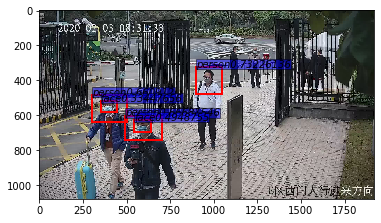

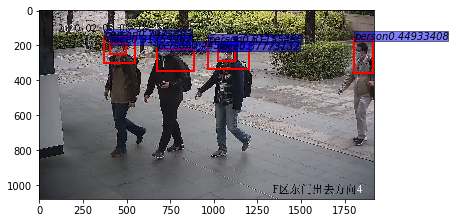

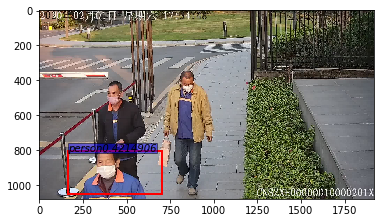

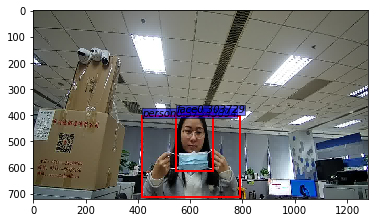

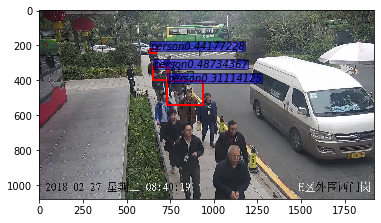

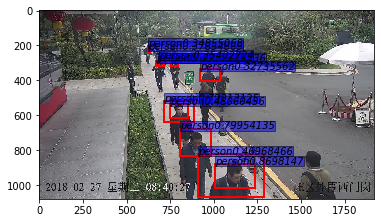

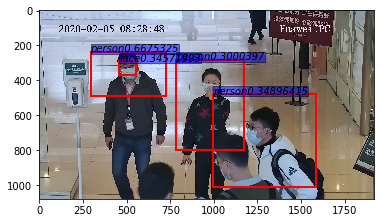

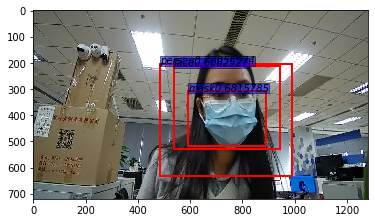

In [4]:
# ---------------yolov3  test-------------------------
cfg = edict({
    "device_id": 0,
    "data_url": 's3://yyq-2/DATA/code/yolov3/mask_detection_500/',
    "ckpt_url": 's3://yyq-2/DATA/code/yolov3/yolov3_out',   #obs://yyq-2/DATA/code/yolov3/yolov3_out/60
    "train_url": 's3:/yyq-2/DATA/yolov3/yolov3_eval_out'
})

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=cfg.device_id)


ckpt_path = './ckpt/'
if not os.path.exists(ckpt_path):
    mox.file.copy_parallel(src_url=args_opt.ckpt_url, dst_url=ckpt_path)
cfg.ckpt_path = os.path.join(ckpt_path, "yolov3-60_15.ckpt") 

data_path = './data/' 
if not os.path.exists(data_path):
    mox.file.copy_parallel(src_url=data_url, dst_url=data_path)

mindrecord_dir_test = os.path.join(data_path,'mindrecord/test')   
prefix = "yolo.mindrecord"
cfg.mindrecord_file = os.path.join(mindrecord_dir_test, prefix)
cfg.image_dir = os.path.join(data_path, "source/test")
if os.path.exists(mindrecord_dir_test):
    print('The mindrecord file had exists!')
else:
    if not os.path.isdir(mindrecord_dir_test):
        os.makedirs(mindrecord_dir_test)
    prefix = "yolo.mindrecord"
    cfg.mindrecord_file = os.path.join(mindrecord_dir_test, prefix)
    print("Create Mindrecord.")
    data_to_mindrecord_byte_image(cfg.image_dir, mindrecord_dir_test, prefix, 1)
    print("Create Mindrecord Done, at {}".format(mindrecord_dir_test))
    # if you need use mindrecord file next time, you can save them to yours obs.
    #mox.file.copy_parallel(src_url=args_opt.mindrecord_dir_test, dst_url=os.path.join(cfg.data_url,'mindspore/test')
print("Start Eval!")

yolo_eval(cfg)